In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import matplotlib as mpl
import utils

In [4]:
# loading the region data
with open('../../../../data/mike_working_dir/identifying_regions_data/adjusted_regions.pkl', 'rb') as f:
		regions = pickle.load(f)
with open('../../../../data/mike_working_dir/identifying_regions_data/twins_era_stats_dict_radius_regions_min_2.pkl', 'rb') as f:
		stats = pickle.load(f)

In [26]:
region_numbers = [387, 61, 202, 287, 207, 361, 137, 184, 36, 19, 9, 163, 16, 270, 194, 82,
								83, 143, 223, 44, 173, 321, 366, 383, 122, 279, 14, 95, 237, 26, 166, 86,
								62, 327, 293, 241, 107, 55, 111, 400, 401]

regions = {f'region_{region}': regions[f'region_{region}'] for region in region_numbers}

In [17]:
for region in regions:
	regions[region]['mean_lat'] = utils.getting_mean_lat(regions[region]['station'])

Loading station CST....
Loading station FUR....
Loading station RNC....
Loading station MMB....
Loading station ASB....
Loading station RIK....
Loading station MSR....
Loading station MAS....
Loading station NOR....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
Loading station PIN....
Loading station C11....
Loading station C05....
Loading station C10....
Loading station LET....
Loading station T19....
Loading station NEW....
Loading station KUJ....
Loading station KNY....
Loading station KAG....
Loading station AQU....
Loading station DUR....
Loading station RNC....
Loading station MAS....
Loading station NOR....
Loading station KEV....
Loading station SOR....
Loading station KUJ....
Loading station KNY....
Loading station KAG....
Loading station JCO....
Loading station DED....
Loading station KAV....
Loading station THL....
Loading station 

In [53]:
# defining the latitude bins in degrees
lat_delimiter = 5

lat_dict = {}
for i in range(20, 90, lat_delimiter):
	lat_dict[i] = {'rsd': pd.DataFrame()}
	for region in regions:
		if regions[region]['mean_lat'] > i and regions[region]['mean_lat'] < i + lat_delimiter:
			lat_dict[i]['rsd'] = pd.concat([lat_dict[i]['rsd'], stats[region]['max_rsd'][['max_rsd', 'MLT']]], axis=0)


## going to breakdown the RSD as a function of MLT on a polar plot much like Jose's plots. Will then split it up via parts of the solar cycle, different deliniations of variables (ie. positive and negative Bz)

In [71]:
# aggregating the data into 24 hour mlt chunks
for lat in lat_dict:
	if lat_dict[lat]['rsd'].empty:
		continue
	lat_dict[lat]['rsd'].dropna(inplace=True)
	lat_dict[lat]['rsd']['MLT'] = lat_dict[lat]['rsd']['MLT'].astype(int)
	lat_dict[lat]['agg_df'] = lat_dict[lat]['rsd'].groupby('MLT').agg(['mean', 'std', 'max', 'median'])['max_rsd']

In [72]:
combined_aggs = pd.DataFrame()
for lat in lat_dict:
	if lat_dict[lat]['rsd'].empty:
		continue
	lat_dict[lat]['agg_df']['lat'] = lat
	combined_aggs = pd.concat([combined_aggs, lat_dict[lat]['agg_df']], axis=0)


Text(0, 0.5, 'Latitude')

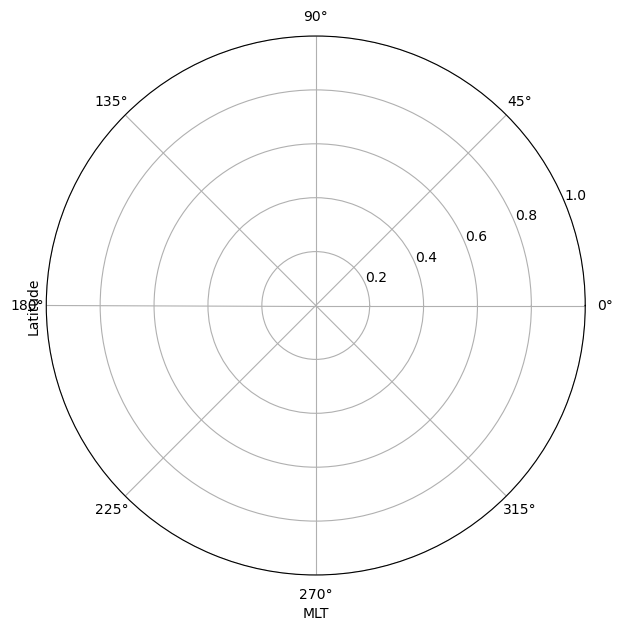

In [78]:
# plotting a heatmap of the RSD by latitude and MLT as a polar plot

value = 'median'

pivot = combined_aggs.pivot_table(index='lat', columns='MLT', values=value)

fig, ax = plt.subplots(figsize=(15, 7))


ax.set_xlabel('MLT')
ax.set_ylabel('Latitude')